In [3]:
import numpy as np
np.random.seed(1)
import os
import random
random.seed(1)
import re
import urllib.request
import zipfile
import lxml.etree
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import KeyedVectors
import tensorflow as tf

Loading BokehJS ...

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/syd_jashim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### In Brief, Steps followed throughout this Nbook: 
#### Task based Embed Learning (Text Classification): 
Label TED talks (textual content) into labels: ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED'] where T,E,D,o refers to Technology, Education, Design, none resp.  
Task: Perform Multi-layered Network with variant embed vectors (random vector, glove, glove vec. trainable) to embed the words to vector such that to label the talks(textual content) as Technology, Entertainment, Design or the combination among them i.e., ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED'].
Performed: using Tensorflow.
Prcodeure: 
    1. Text retrieval from 'ted_en-20160408.xml' (//content/text()) and labels from  '//head/keywords/text()'.
    2. preprocess sentences
       2.1 Exclude characters except alphabets and numbers. Also, convert uppercase to lower
       2.2 Remove words those are in stopwords(nltk.corpus.stopwords('english')) //exclude unkown words
       2.3 Tokenize words from texts such that the most common and least used are removed
       2.4 Exclude short strings (size: <500) 
    3. create Dictionary (for tokens): word2id and id2word to be used for word embedding
    4. constraint inputs(texts) to fixed length (length = 500) //if string is shorter pad it with '<UNK>' token
    5. split dataset unifromly (based on their class ratio) into train, validation and test (similar to stratifiedKFold from scikit)
    6. convert labels to OHE (one hot encoder) //used as output(labels) in LSTM
    7. Perform Multi-layered NN using Tensorflow with variants of embed vectors. 

In [4]:
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [5]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = doc.xpath('//content/text()')
label = doc.xpath('//head/keywords/text()')
del doc
len(input_text)

2085

In [6]:
#zipfile.ZipFile('ted_en-20160408.zip','r').extractall()
#%cat ted_en-20160408.xml

In [7]:
# Preprocess sentences to exclude all characters except alphabets and numbers
texts = [re.sub(r'\([^)]*\)', '',text) for text in input_text]
texts = [re.sub('r([^a-zA-Z0-9\s])',' ',text) for text in texts] #Included '.'
texts = [re.sub('[^a-zA-Z0-9\']',' ',text) for text in texts] #To replace '.' with ' '
texts = [re.sub('[^a-zA-Z0-9 ]','',text) for text in texts]
texts = [text.lower() for text in texts] #uppercase->lowercase
texts = [text for text in texts if text not in stopwords.words('english')] #exclude unknown(~english) words. @Self: Can be removed after verifying the result

In [8]:
texts[2069][:160]

'   thank you   thank you very much  like the speaker before me    i am a ted virgin  i guess  im also the first time here  and      i dont know what to say   im'

In [9]:
# Consider only those texts which are greater in length (>500)
text_labels = zip(texts,label)
texts = [text_label for text_label in text_labels if len(text_label[0]) > 500]
print('number of text greater than 500 words are:',len(texts))

number of text greater than 500 words are: 2076


In [10]:
texts,labels = zip(*texts)

In [11]:
words = [words for text in texts for words in text.split()]
words_count = Counter(words)
words_most_common =[word for word,count in words_count.most_common(100)]
words_least_common = [word for word,count in words_count.most_common() if count==1]

In [12]:
# Remove mostly used and least used words
to_remove = words_most_common + words_least_common
words_to_remove = set(to_remove)
tokens = [word for word in words if word not in words_to_remove] #will be used during T-SNE
print('size of Token:',len(tokens)) 

size of Token: 1948385


In [13]:
# Text after removing unnecessary words
texts = [[word for word in text.split() if word not in words_to_remove]for text in texts]

In [14]:
len(texts)

2076

In [15]:
texts[2069][:10]

['present',
 'three',
 'projects',
 'rapid',
 'fire',
 'much',
 'reinforce',
 'three',
 'ideas',
 'rapid']

In [16]:
# Encode labels as ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']
label_coded = ['ooo']*len(labels)
for i,keyword in enumerate(labels):
    key = keyword.split(', ')
    label = list(label_coded[i])
    if 'technology' in key:
        label[0] = 'T'
    if 'entertainment' in key:
        label[1] = 'E'
    if 'design' in key:
        label[2] = 'D'
    else:
        pass
    label_coded[i] =''.join(label) 

In [17]:
# Count number of each labels
count_labels=Counter(label_coded)
label_count = [word_count for word_count in count_labels.most_common()]
label_count

[('ooo', 1130),
 ('Too', 389),
 ('oEo', 169),
 ('ooD', 158),
 ('ToD', 137),
 ('TEo', 36),
 ('TED', 33),
 ('oED', 24)]

In [18]:
#Implement OneHot Encoder for labels
ohe = np.zeros(shape=(len(labels),8),dtype='int16')
label_lookup = ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']
for i,label in enumerate(label_coded):
    ohe[i][label_lookup.index(label)] = 1
print(ohe[:10])    

[[1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]


In [19]:

tokens.append('<UNK>') #will be included in those sentences which are shorter than required fixed length sentences.
tokens.append('<PAD>') #Added PAD
vocab = list(set(tokens))
print('size of vocabulary:',len(vocab))
id2word = dict(enumerate(vocab))
word2id = dict((val,key) for (key,val) in id2word.items())

size of vocabulary: 37328


In [20]:
# To embed word to dim(N,D=50) of glove
def glove_embed(vocab=vocab,word2id=word2id):
    glove = KeyedVectors.load_word2vec_format('glove.6B.50d.w2vformat.txt', binary=False)
    word_embed = np.random.uniform(-0.1,0.1,size=(len(vocab),50)) #[-0.1,0.1] ==> as similar to the range of glove vectors.
    for word,i in word2id.items():
        if word in glove.vocab:
            word_embed[i] = glove[word]
    return word_embed
word_embed = glove_embed(vocab,word2id)

In [21]:
word_embed.shape

(37328, 50)

In [22]:
# Stripping Text to fall within length of 500; incase if it is shorter then padd with '<UNK>'
length = 500 #sentence length
stripped_text = []#np.zeros((len(texts),length)
for i,text in enumerate(texts):
    inputs = []
    if len(text) >= 500:
        inputs.extend(text[:500])
    else:
        extra_length = 500-len(text)
        extra = ['<PAD>']*extra_length
        word_with_extra = text + extra
        inputs.extend(word_with_extra)
    stripped_text.append(inputs) 

In [23]:
#convert words in texts to its id - requirement for tf.nn.embedding_lookup - to find the corresponding word vectors 

inputs = []
text_ids = []
for text in stripped_text:
    for word in text:
        i = word2id[word]
        inputs.append(i)
    text_ids.append(inputs)
    inputs = []
            

In [24]:
text_ids[0][100] , id2word[text_ids[0][100]], stripped_text[0][100], word2id['<UNK>']

(24772, 'even', 'even', 11491)

In [25]:
#Split data into train,val and test based on class-freq.
data = list(zip(text_ids,ohe))
tr_size = round(0.8*len(data))
vl_size = round(0.1*len(data))
te_size = tr_size + vl_size
n_classes = ohe.shape[1]
train_Xy , val_Xy , test_Xy = [],[],[]
for i in np.arange(n_classes):
    j = np.zeros(n_classes)
    j[i] = 1
    temp = [text_ohe for text_ohe in data if text_ohe[1][i]==j[i]]
    temp_len = len(temp)
    tr_split = round(temp_len*0.8)
    val_split = round(temp_len*0.9)
    train_Xy.extend(temp[:tr_split])
    val_Xy.extend(temp[tr_split:val_split])
    test_Xy.extend(temp[val_split:])
random.shuffle(train_Xy)
random.shuffle(val_Xy)
random.shuffle(test_Xy)

In [26]:
def conv2numpy(X):
    x,y = zip(*X)
    x = np.vstack(x)
    y = np.vstack(y)
    return x,y

train_X, train_y = conv2numpy(train_Xy)
val_X, val_y = conv2numpy(val_Xy)
test_X, test_y = conv2numpy(test_Xy)

In [27]:
len(val_y), len(train_X), len(test_y), train_X[:,:400].shape

(208, 1660, 208, (1660, 400))

In [28]:
#To plot loss: val and train loss.
from bokeh.plotting import figure, show, output_file, gridplot
def loss_graph(tr_loss_hist,val_loss_hist):
    p = figure(title="loss graph", y_axis_type="linear",y_range=(min(tr_loss_hist),max(tr_loss_hist)))

    p.line(range(len(tr_loss_hist)), tr_loss_hist, legend="training loss",
           line_color="tomato",line_width=2)

    p.line(range(len(val_loss_hist)), val_loss_hist, legend="val loss",
           line_color="gold", line_width=2)

    p.legend.location = "top_right"

    p.xaxis.axis_label = 'Iterations'
    p.yaxis.axis_label = 'Error'

    output_file("loss_graph.html", title="loss graph")
    show(gridplot(p, ncols=20, plot_width=400, plot_height=400))
    show(p)  # open a browser
    return None


In [29]:
##To plot accuracy: val and train acc.
from bokeh.plotting import figure, show, output_file, gridplot
def acc_graph(train_acc_hist,val_acc_hist):
    p = figure(title="acc graph", y_axis_type="linear",
               y_range=(min(train_acc_hist),max(max(train_acc_hist),max(val_acc_hist))))
    p.line(range(len(train_acc_hist)), train_acc_hist, legend="training acc",line_color="tomato",line_width=2)

    p.line(range(len(val_acc_hist)), val_acc_hist, legend="val acc",line_color="gold", line_width=2)

    p.legend.location = "top_right"

    p.xaxis.axis_label = 'Epoch'
    p.yaxis.axis_label = 'Acc.'

    output_file("acc_graph.html", title="Acc. graph")
    show(gridplot(p, ncols=20, plot_width=400, plot_height=400))
    show(p)  # open a browser
    return None

In [30]:
# To perform TSNE on the embedded vector.
from sklearn.manifold import TSNE
def tsne_plot(tokens,word2id,embedded):
    count_token = Counter(tokens)
    common_token = [tok for (tok,count) in count_token.most_common(1000)]
    com_token_id = [word2id[tok] for tok in common_token]
    com_token_vec = embedded[com_token_id,:]

    tsne = TSNE(n_components=2, random_state=0)
    words_top_ted_tsne = tsne.fit_transform(com_token_vec)

    p = figure(tools="pan,wheel_zoom,reset,save",
               toolbar_location="above",
               title="T-SNE for most common words")

    source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                        x2=words_top_ted_tsne[:,1],
                                        names=common_token))

    p.scatter(x="x1", y="x2", size=8, source=source)

    labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')
    p.add_layout(labels)

    show(p)
    return None

In [31]:
# the above loss and acc graph plot function by bokeh will render dynamic image
##To plot accuracy: val and train acc.
##To plot accuracy: val and train loss.
def plot_graph(train,val,Title=None):
    fig = plt.figure(figsize=(20,10))
    plt.title(Title)
    plt.plot(train,color='r',label='Train')
    plt.plot(val,color='y',label='Validation')
    plt.legend(loc='upper right')
    min_X = min(train+val)
    max_X = max(train+val)
    plt.ylim(min_X,max_X)
    plt.xlim(0,len(train))
    plt.xticks(range(len(train)))
    plt.xlabel('No. of Epoch')
    if 'loss' in Title:
        plt.ylabel('loss')
    elif 'acc' in Title:
        plt.ylabel('accuracy')
    plt.show()

Word embeddings can be learned as parameters in the model (either starting from random values or starting from a word embedding model, such as word2vec or GloVe),
or they you can use fixed values (again, word2vec or Glove).

Word embeddings can be learned as parameters in the model - By fixing the 'Glove' values (returned from glove_embed(...)) as the initial weight or by initilising it with random values. 

### To perform TED Classification from Text to labels. 
Focused on the models performance on various scenario's of embedded word vector (Dim: len(vocab),50).
1. 'random': Word vector initialised with normal distribution and it is as a parameter in the model; Thus, can be learned while training.
2. 'glove fixed': word vector initilasied with Glove vector (as def. in glove_embed(..)) which is not trainable.
3. 'glove train': word vector initilasied with Glove vector (as def. in glove_embed(..)) but trainable; thus, learned while training the model.

The above scenario's definition is done in Embed_Word(...) within the below class.   


In [52]:
def glove_embed(vocab=vocab,word2id=word2id):
    return word_embed #As i will be calling it frequently thus retained it in the memory
tf.reset_default_graph()
class Graph():
    def __init__(self,sent_length):
        self.graph = tf.Graph()
        self.embed_vector = None
        self.hidden = None
        self.dropout = None
        self.logits = None
        self.loss = None
        self.embedded = None
        self.optim = None
        self.accuracy = None
        self.sent_length = sent_length
        self.lrn_rate = None
        with self.graph.as_default():
            tf.set_random_seed(1)
            self.X = tf.placeholder(dtype=tf.int32,shape=(None,self.sent_length),name='inputs')
            self.Y = tf.placeholder(dtype=tf.int32,shape=(None,8),name='labels')
            self.dropout = tf.placeholder(dtype=tf.float32,shape=(),name='labels')

        
    def Embed_Word(self,len_vocab,embed_attr):
        
        with self.graph.as_default():
            tf.set_random_seed(1)
            if embed_attr == 'random': #Random Embed: LEarn Embed vector while training
                self.embed_vector = tf.Variable(tf.random_normal(shape=(len(vocab),50),seed=1),name='embed_vector',trainable=True)
            elif embed_attr == 'glove-fixed': #Glove-Fixed
                self.embed_vector = tf.Variable(tf.cast(glove_embed(),tf.float32),name='embed_vector',trainable=False) #avoid tf.constant(..): NOT memory efficient.
            elif embed_attr == 'glove-train': #Glove-Trainable: Learn embed_vector while training from fixed Glove embed vector
                self.embed_vector = tf.Variable(tf.cast(glove_embed(),tf.float32),name='embed_vector',trainable=True)
            return 0

    def Create_Graph(self,lrn_rate=0.01,hidden_units=50,n_classes = 8):
        
        with self.graph.as_default():
            tf.set_random_seed(1)
#            print(self.embed_vector.shape,self.X.shape)
            self.embedded = tf.nn.embedding_lookup(self.embed_vector,self.X,name='embedded_word')
            hidden = tf.contrib.layers.fully_connected(self.embedded,hidden_units,activation_fn=tf.nn.tanh)#,weights_regularizer=tf.nn.l2_loss)
            hidden = tf.nn.dropout(hidden,self.dropout,seed=1)
            self.logits = tf.contrib.layers.fully_connected(hidden,n_classes,activation_fn=None)#,weights_regularizer=tf.nn.l2_loss)
            self.logits = tf.reduce_sum(self.logits,axis=1)
#            print('logits shape:',self.logits.shape)    
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,labels=self.Y))
#            self.lrn_rate = tf.cast(lrn_rate,tf.float32)
            global_step = tf.Variable(0,trainable=False)
            self.lrn_rate = tf.train.inverse_time_decay(learning_rate=lrn_rate,global_step=global_step,decay_rate=0.05,decay_steps=5) #d_steps = 0.9999
            self.optim = tf.train.AdamOptimizer(self.lrn_rate).minimize(self.loss,global_step=global_step)
            predict = tf.argmax(self.logits,axis=1)
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(predict,tf.argmax(self.Y,axis=1)),dtype=tf.float32))
        return None

    def Execute_Session(self,train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=0.5,num_epoch = 2,batch_size=100):
        
        best_val = -1
        train_acc_prev = -1
        same_acc_count = 0
        loss_hist,val_acc_hist,train_acc_hist = [],[],[]
        tr_loss_hist, val_loss_hist = [],[]
        path = './models/'+file_name
        with tf.Session(graph=self.graph) as sess:
            tf.set_random_seed(1)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            for e in range(num_epoch):
                n, v = 0,0
                num_iter = len(train_X)//batch_size   #No. of Batches     
                if num_iter == 0:
                    num_iter = len(train_X)

                for i in range(num_iter): 
                    feed_dict = {self.X:train_X[n:n+batch_size,:self.sent_length],self.Y:train_y[n:n+batch_size],self.dropout:dropout}
                    _,tr_loss = sess.run([self.optim,self.loss],feed_dict=feed_dict)
                    n += batch_size

                val_loss_iter = []
                tr_loss,train_acc = sess.run([self.loss,self.accuracy],feed_dict={self.X:train_X[:,:self.sent_length],self.Y:train_y,self.dropout:1.0}) #loss for the entire train
                val_loss,val_acc,lrn_rate = sess.run([self.loss,self.accuracy,self.lrn_rate],feed_dict={self.X:val_X[:,:self.sent_length],self.Y:val_y,self.dropout:1.0})
                val_loss_hist.append(val_loss)
                tr_loss_hist.append(tr_loss)
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                if val_acc > best_val:
                    best_val = val_acc
                    save_path = saver.save(sess,path)
                if train_acc_prev == train_acc:
                    same_acc_count += 1                    
                    if same_acc_count > 10:
                       print('No change in val acc continuously for 10 epochs')
                       break 
                train_acc_prev = train_acc

                    
                print('epoch:',e+1,'tr loss:',tr_loss,'val loss:',val_loss,'train acc:',train_acc,'val acc:',val_acc)#, 'with lrn_rate:',lrn_rate)

                    
            embedded = sess.run(self.embed_vector) #to compute T-SNE
#            print('embedded.shape',embedded.shape)
            print('Best val_acc:',best_val)
            saver.restore(sess, path) #model restore
            test_acc = sess.run(self.accuracy,feed_dict={self.X:test_X[:,:self.sent_length],self.Y:test_y,self.dropout:1.0})
            print('Test acc. with best model:',test_acc)    
        return (embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist)
if __name__ == "__main__":
    tf.reset_default_graph()
    model = Graph(sent_length=400)
    model.Embed_Word(len_vocab=len(vocab),embed_attr='glove-train')   
    model.Create_Graph(lrn_rate=0.03,hidden_units=100) 
    file_name = 'practical-2_Glove_Train.ckpt'
    embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist = \
    model.Execute_Session(train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=1.00,num_epoch = 200,batch_size=200)

epoch: 1 tr loss: 358.938 val loss: 400.387 train acc: 0.544578 val acc: 0.538462
epoch: 2 tr loss: 121.156 val loss: 158.894 train acc: 0.568072 val acc: 0.490385
epoch: 3 tr loss: 38.6499 val loss: 76.2243 train acc: 0.698795 val acc: 0.586538
epoch: 4 tr loss: 21.4347 val loss: 57.2459 train acc: 0.733133 val acc: 0.605769
epoch: 5 tr loss: 7.43475 val loss: 48.3472 train acc: 0.875301 val acc: 0.591346
epoch: 6 tr loss: 3.47688 val loss: 44.9711 train acc: 0.934337 val acc: 0.572115
epoch: 7 tr loss: 2.21068 val loss: 39.6427 train acc: 0.955422 val acc: 0.567308
epoch: 8 tr loss: 1.77648 val loss: 38.656 train acc: 0.975904 val acc: 0.581731
epoch: 9 tr loss: 1.68676 val loss: 37.1588 train acc: 0.979518 val acc: 0.576923
epoch: 10 tr loss: 1.71162 val loss: 36.9125 train acc: 0.981325 val acc: 0.600962
epoch: 11 tr loss: 1.57684 val loss: 35.374 train acc: 0.98494 val acc: 0.596154
epoch: 12 tr loss: 1.52125 val loss: 35.0488 train acc: 0.986747 val acc: 0.581731
epoch: 13 tr los

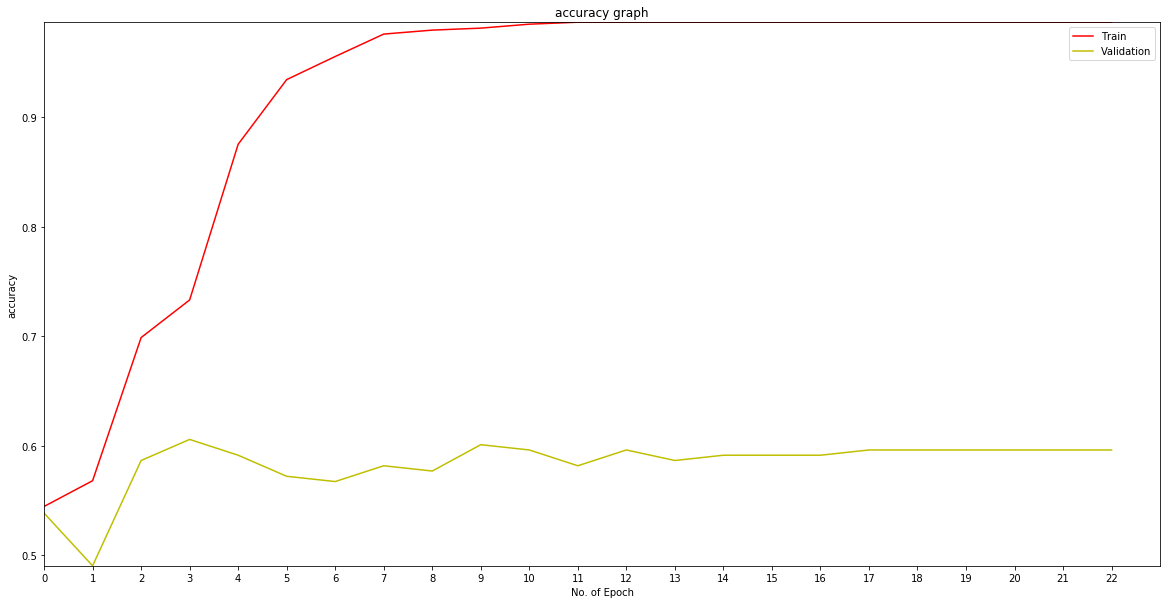

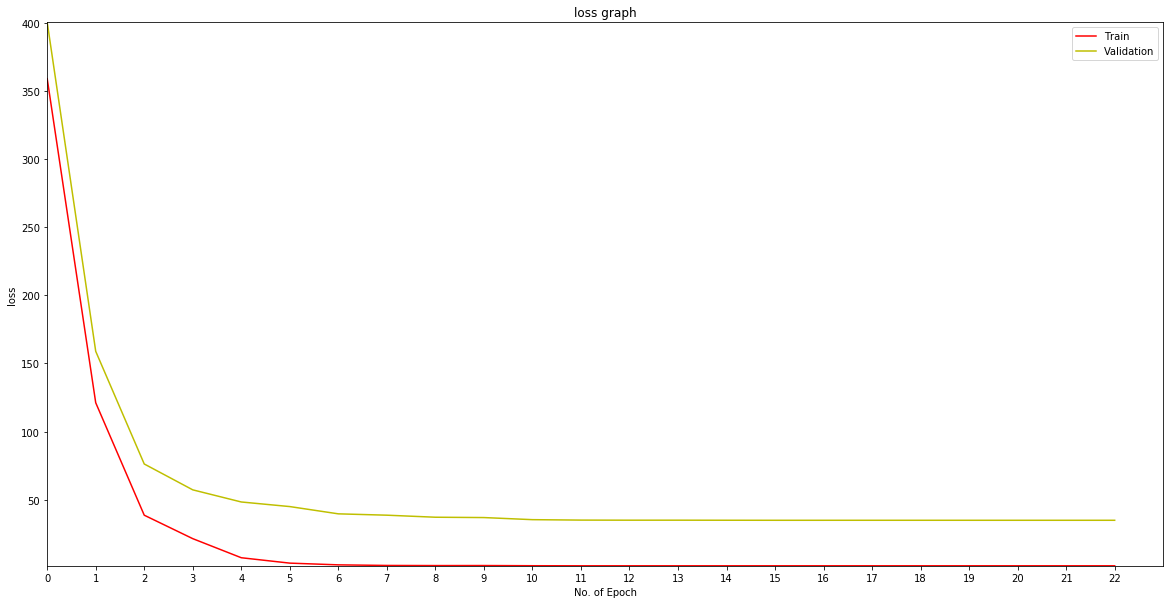

In [53]:
plot_graph(train_acc_hist,val_acc_hist,Title='accuracy graph')
plot_graph(tr_loss_hist,val_loss_hist,Title='loss graph')

In [54]:
#acc_graph(train_acc_hist,val_acc_hist)

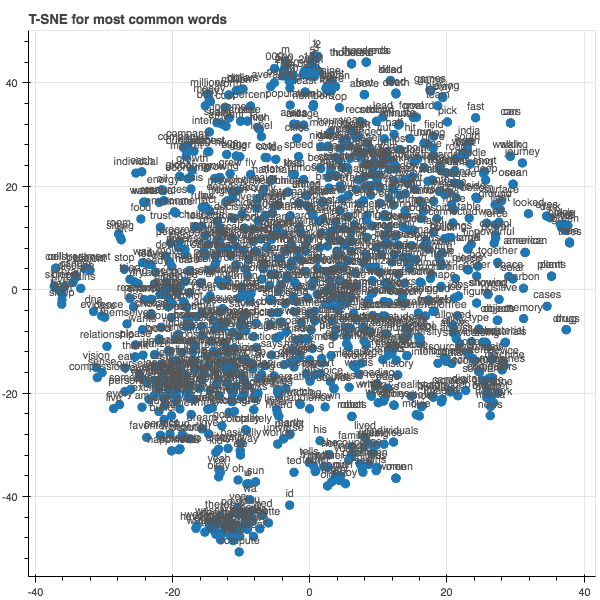

In [56]:
# Dynamic Images of Bokeh can't be displayed in github
#tsne_plot(tokens,word2id,embedded)
from IPython.display import Image
Image(filename='src/glv_train_tsne.png')

In [48]:
tf.reset_default_graph()

if __name__ == "__main__":
    tf.reset_default_graph()
    model = Graph(sent_length=400)
    model.Embed_Word(len_vocab=len(vocab),embed_attr='glove-train')   
    model.Create_Graph(lrn_rate=0.03,hidden_units=100) 
    file_name = 'practical-2_Glove_Train_Do.ckpt'
    embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist = \
    model.Execute_Session(train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=0.5,num_epoch = 200,batch_size=200)

epoch: 1 tr loss: 400.768 val loss: 442.59 train acc: 0.543373 val acc: 0.538462
epoch: 2 tr loss: 114.472 val loss: 157.978 train acc: 0.535542 val acc: 0.475962
epoch: 3 tr loss: 62.9837 val loss: 99.9441 train acc: 0.637349 val acc: 0.557692
epoch: 4 tr loss: 31.8029 val loss: 62.8938 train acc: 0.644578 val acc: 0.552885
epoch: 5 tr loss: 13.9926 val loss: 58.328 train acc: 0.81506 val acc: 0.581731
epoch: 6 tr loss: 4.66943 val loss: 45.0172 train acc: 0.892771 val acc: 0.596154
epoch: 7 tr loss: 2.23822 val loss: 38.2159 train acc: 0.95 val acc: 0.615385
epoch: 8 tr loss: 1.82338 val loss: 36.3104 train acc: 0.966867 val acc: 0.620192
epoch: 9 tr loss: 1.59627 val loss: 34.2168 train acc: 0.972289 val acc: 0.596154
epoch: 10 tr loss: 1.6841 val loss: 34.7873 train acc: 0.977711 val acc: 0.615385
epoch: 11 tr loss: 1.55169 val loss: 34.9712 train acc: 0.981325 val acc: 0.620192
epoch: 12 tr loss: 1.43643 val loss: 35.4222 train acc: 0.98494 val acc: 0.610577
epoch: 13 tr loss: 1.4

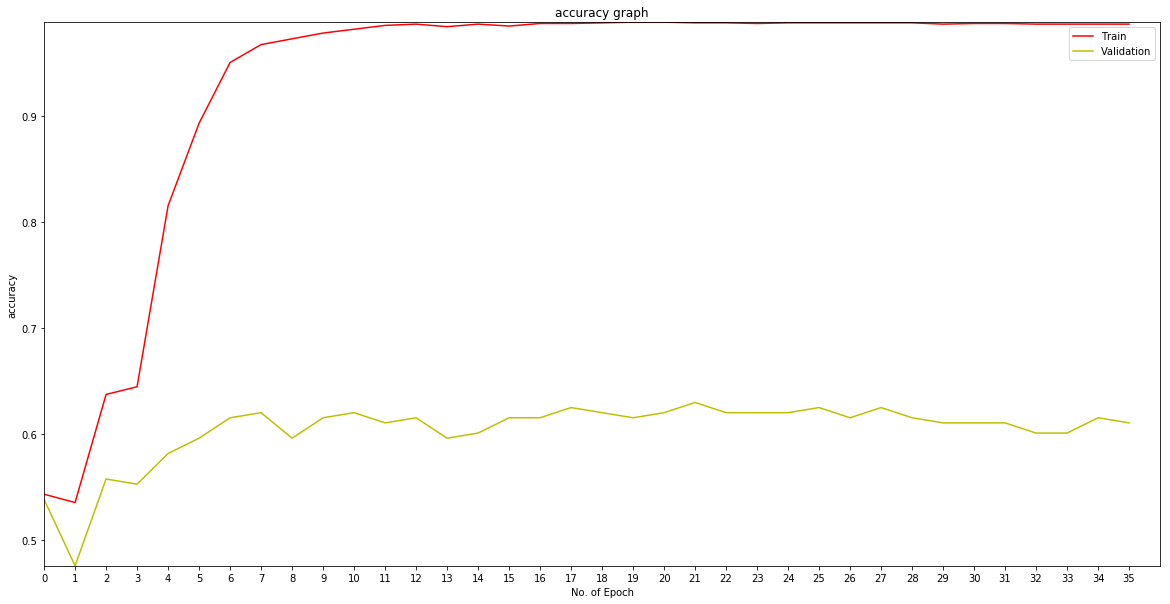

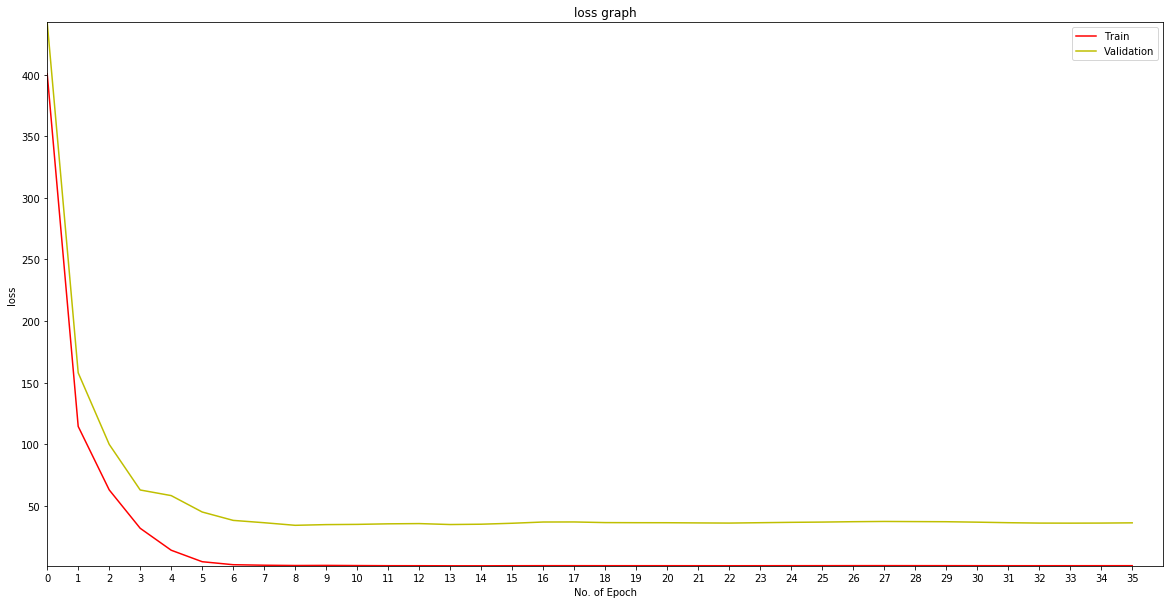

In [49]:
plot_graph(train_acc_hist,val_acc_hist,Title='accuracy graph')
plot_graph(tr_loss_hist,val_loss_hist,Title='loss graph')

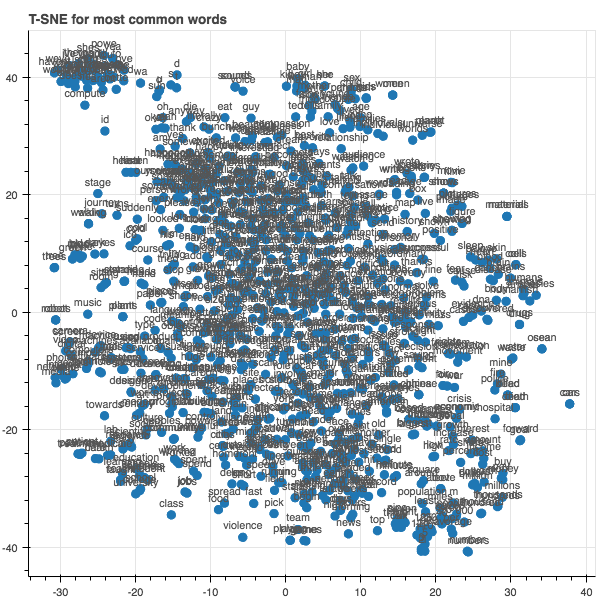

In [57]:
#tsne_plot(tokens,word2id,embedded)
Image(filename='src/glv_train_do_tsne.png')

In [38]:
# Glove-Fixed : With Dropout:1.0
if __name__ == "__main__":
    tf.reset_default_graph()
    model = Graph(sent_length=400)
    model.Embed_Word(len_vocab=len(vocab),embed_attr='glove-fixed') #glove-fixed: test_acc:0.524, do=0.5, hidd=35,lrn=0.03    
    model.Create_Graph(lrn_rate=0.03,hidden_units=100) #glove-train: 0.56, do=0.7, lrn=0.02,hid=35
    file_name = 'practical-2_Glove_Fixed.ckpt'
    embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist = \
    model.Execute_Session(train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=1.0,num_epoch = 100,batch_size=200)

epoch: 1 tr loss: 519.973 val loss: 546.946 train acc: 0.545783 val acc: 0.548077
epoch: 2 tr loss: 344.148 val loss: 365.486 train acc: 0.557229 val acc: 0.5625
epoch: 3 tr loss: 114.152 val loss: 112.37 train acc: 0.549398 val acc: 0.557692
epoch: 4 tr loss: 90.7838 val loss: 95.0729 train acc: 0.51988 val acc: 0.528846
epoch: 5 tr loss: 65.2476 val loss: 64.0196 train acc: 0.554819 val acc: 0.567308
epoch: 6 tr loss: 30.9092 val loss: 32.8528 train acc: 0.551205 val acc: 0.548077
epoch: 7 tr loss: 23.3231 val loss: 26.2843 train acc: 0.544578 val acc: 0.548077
epoch: 8 tr loss: 19.179 val loss: 22.2975 train acc: 0.471687 val acc: 0.432692
epoch: 9 tr loss: 14.255 val loss: 19.7287 train acc: 0.553614 val acc: 0.509615
epoch: 10 tr loss: 12.0341 val loss: 17.9573 train acc: 0.593976 val acc: 0.591346
epoch: 11 tr loss: 11.8193 val loss: 14.5923 train acc: 0.477108 val acc: 0.485577
epoch: 12 tr loss: 23.4947 val loss: 26.2243 train acc: 0.272289 val acc: 0.225962
epoch: 13 tr loss: 

Test acc. with best model: 0.576923


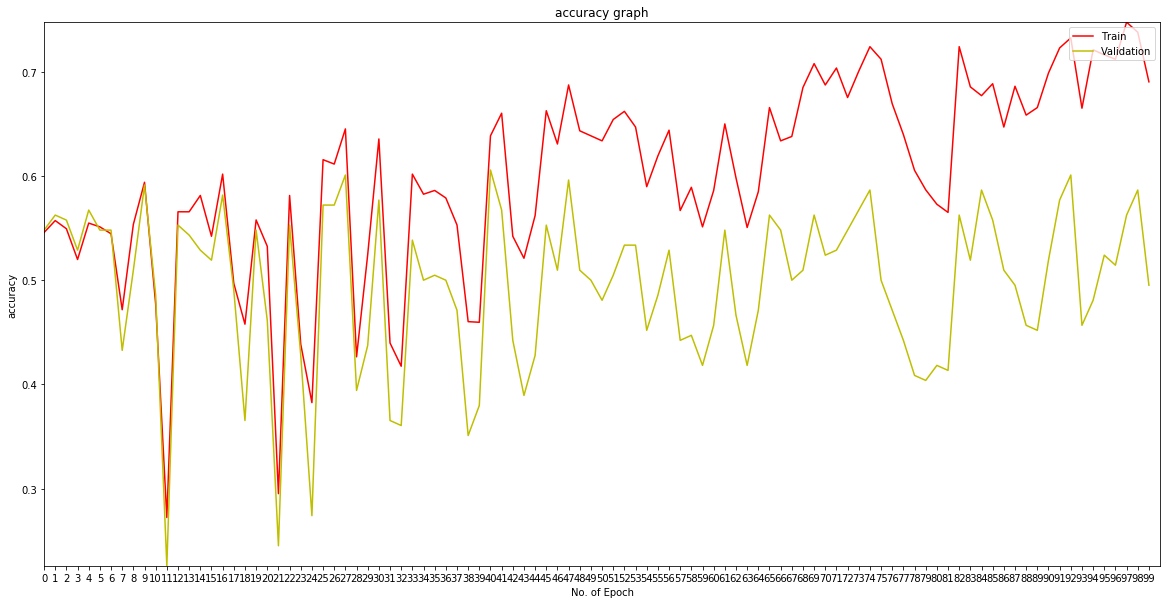

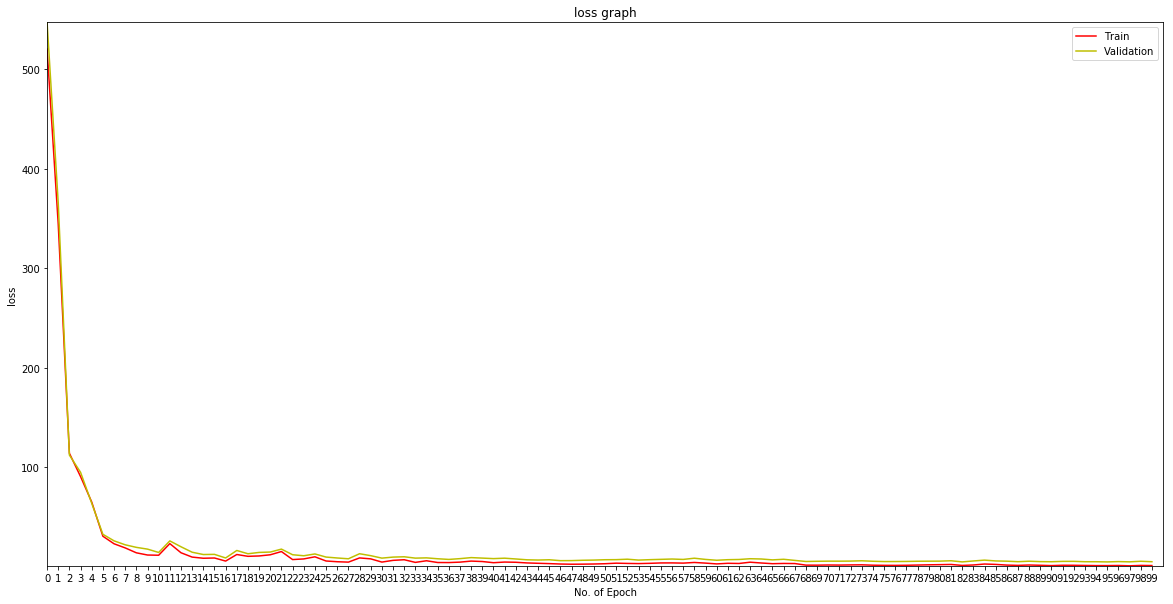

In [39]:
plot_graph(train_acc_hist,val_acc_hist,Title='accuracy graph')
plot_graph(tr_loss_hist,val_loss_hist,Title='loss graph')

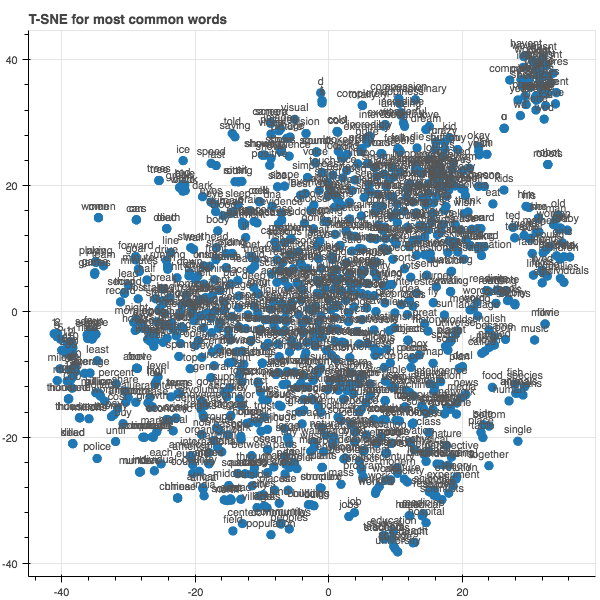

In [58]:
#tsne_plot(tokens,word2id,embedded)
Image(filename='src/glv_fixed_tsne.png')

In [41]:
# Glove-Fixed : With Dropout:0.50
if __name__ == "__main__":
    tf.reset_default_graph()
    model = Graph(sent_length=400)
    model.Embed_Word(len_vocab=len(vocab),embed_attr='glove-fixed') #glove-fixed: test_acc:0.524, do=0.5, hidd=35,lrn=0.03    
    model.Create_Graph(lrn_rate=0.03,hidden_units=100) #glove-train: 0.56, do=0.7, lrn=0.02,hid=35
    file_name = 'practical-2_Glove_Fixed_with_Dropout.ckpt'
    embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist = \
    model.Execute_Session(train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=0.5,num_epoch = 100,batch_size=200)

epoch: 1 tr loss: 512.266 val loss: 540.51 train acc: 0.550602 val acc: 0.548077
epoch: 2 tr loss: 330.943 val loss: 355.593 train acc: 0.554819 val acc: 0.5625
epoch: 3 tr loss: 142.421 val loss: 141.1 train acc: 0.536747 val acc: 0.538462
epoch: 4 tr loss: 123.969 val loss: 135.448 train acc: 0.525904 val acc: 0.524038
epoch: 5 tr loss: 67.4383 val loss: 66.7023 train acc: 0.511446 val acc: 0.533654
epoch: 6 tr loss: 47.409 val loss: 53.4172 train acc: 0.581325 val acc: 0.581731
epoch: 7 tr loss: 33.2942 val loss: 37.8362 train acc: 0.555422 val acc: 0.5625
epoch: 8 tr loss: 21.9019 val loss: 22.614 train acc: 0.583133 val acc: 0.591346
epoch: 9 tr loss: 16.8749 val loss: 20.6561 train acc: 0.589759 val acc: 0.572115
epoch: 10 tr loss: 15.1662 val loss: 18.2689 train acc: 0.498193 val acc: 0.471154
epoch: 11 tr loss: 14.1853 val loss: 17.0949 train acc: 0.507831 val acc: 0.466346
epoch: 12 tr loss: 9.99518 val loss: 14.499 train acc: 0.630723 val acc: 0.596154
epoch: 13 tr loss: 9.04

Test acc. with best model: 0.581731


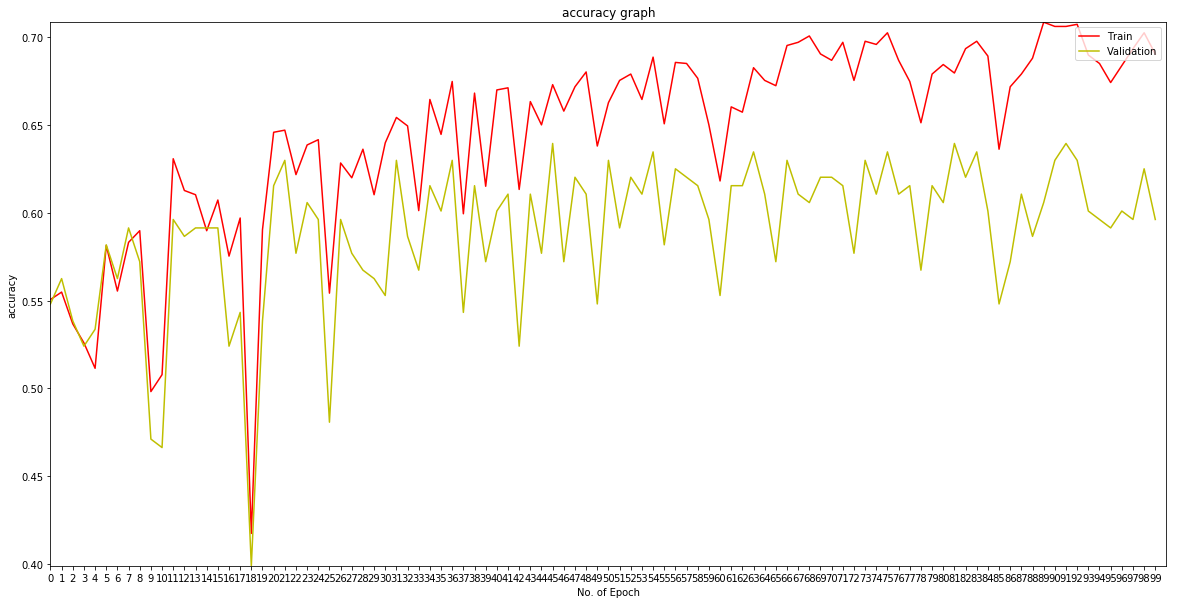

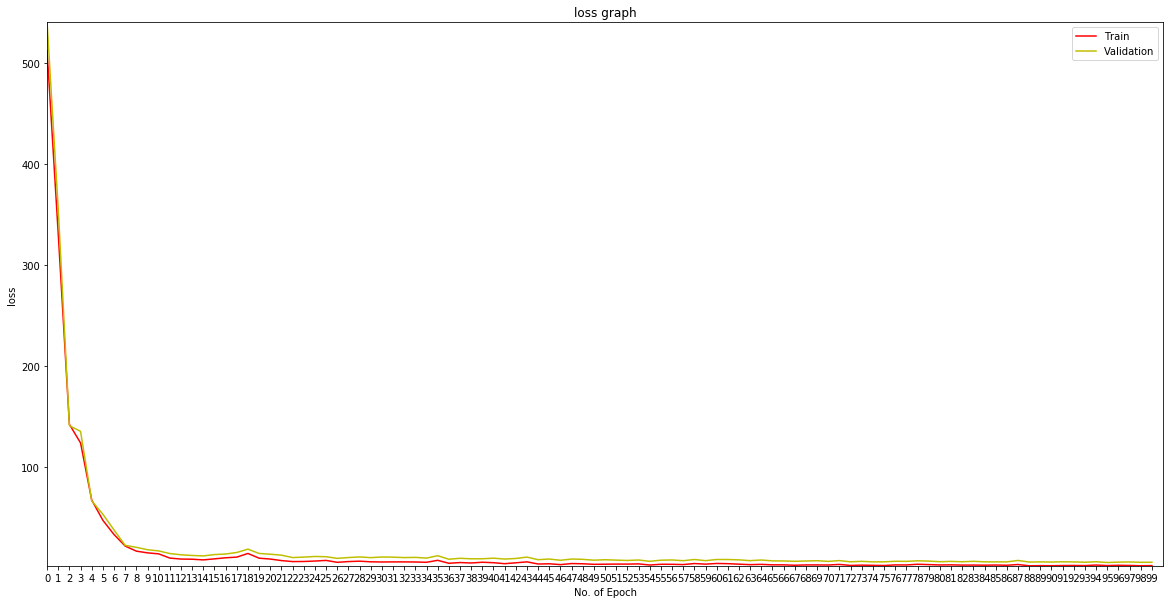

In [42]:
plot_graph(train_acc_hist,val_acc_hist,Title='accuracy graph')
plot_graph(tr_loss_hist,val_loss_hist,Title='loss graph')

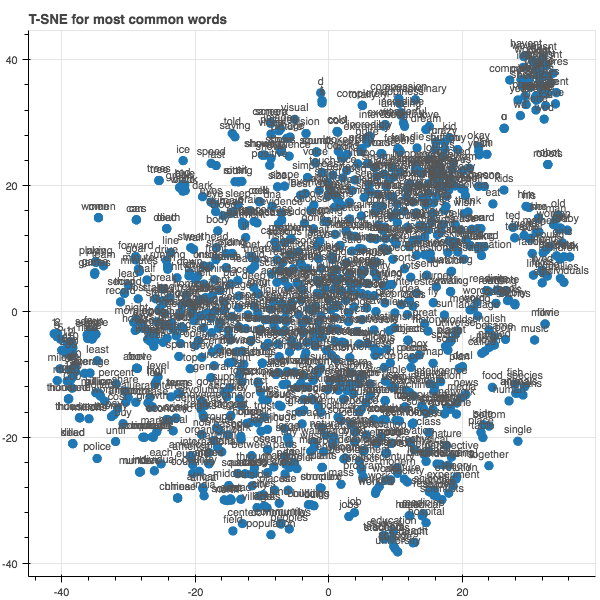

In [59]:
#tsne_plot(tokens,word2id,embedded)
Image(filename='src/glv_fixed_do_tsne.png')

In [44]:
# random : With Dropout:1.0
if __name__ == "__main__":
    tf.reset_default_graph()
    model = Graph(sent_length=400)
    model.Embed_Word(len_vocab=len(vocab),embed_attr='random') #glove-fixed: test_acc:0.524, do=0.5, hidd=35,lrn=0.03    
    model.Create_Graph(lrn_rate=0.03,hidden_units=100) #glove-train: 0.56, do=0.7, lrn=0.02,hid=35
    file_name = 'practical-2_Random.ckpt'
    embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist = \
    model.Execute_Session(train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=1.0,num_epoch = 100,batch_size=200)

epoch: 1 tr loss: 33.2473 val loss: 55.9095 train acc: 0.443374 val acc: 0.370192
epoch: 2 tr loss: 34.0139 val loss: 61.4998 train acc: 0.637952 val acc: 0.461538
epoch: 3 tr loss: 10.9764 val loss: 34.6428 train acc: 0.740964 val acc: 0.408654
epoch: 4 tr loss: 4.19428 val loss: 24.7424 train acc: 0.895181 val acc: 0.495192
epoch: 5 tr loss: 3.0832 val loss: 25.6864 train acc: 0.889157 val acc: 0.475962
epoch: 6 tr loss: 2.65361 val loss: 27.7017 train acc: 0.942771 val acc: 0.495192
epoch: 7 tr loss: 1.89754 val loss: 24.7143 train acc: 0.963253 val acc: 0.485577
epoch: 8 tr loss: 2.94648 val loss: 28.7594 train acc: 0.953012 val acc: 0.533654
epoch: 9 tr loss: 2.77565 val loss: 30.4745 train acc: 0.969277 val acc: 0.504808
epoch: 10 tr loss: 1.99979 val loss: 31.4231 train acc: 0.972289 val acc: 0.5
epoch: 11 tr loss: 2.28695 val loss: 29.0882 train acc: 0.96988 val acc: 0.504808
epoch: 12 tr loss: 1.64355 val loss: 29.3964 train acc: 0.975904 val acc: 0.504808
epoch: 13 tr loss: 1

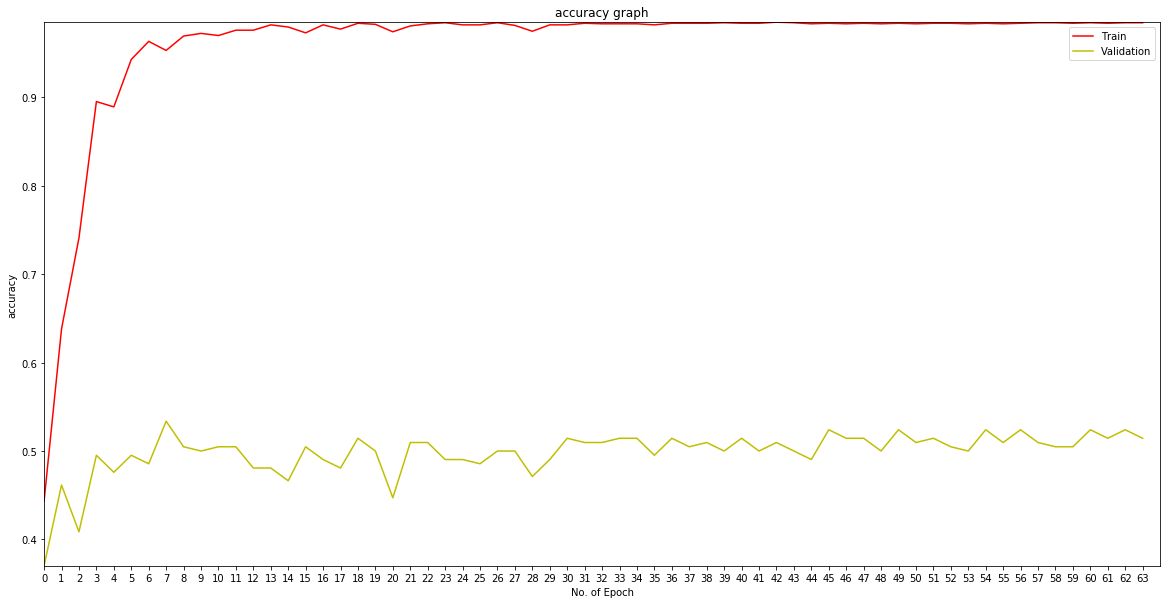

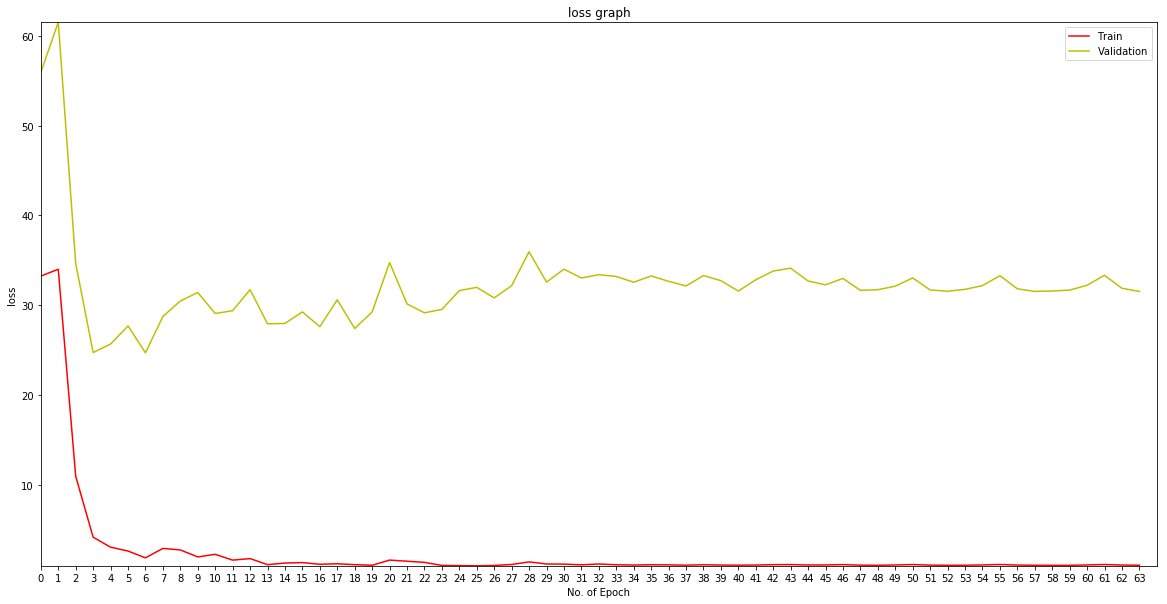

In [45]:
plot_graph(train_acc_hist,val_acc_hist,Title='accuracy graph')
plot_graph(tr_loss_hist,val_loss_hist,Title='loss graph')

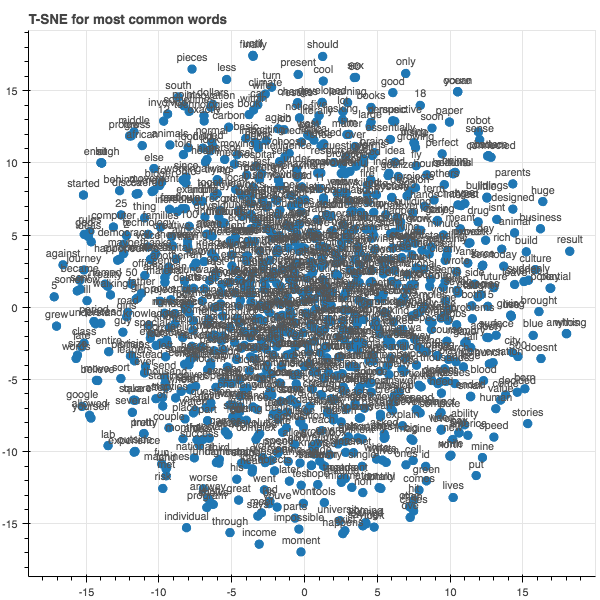

In [60]:
#tsne_plot(tokens,word2id,embedded)
Image(filename='src/random_tsne.png')

In [62]:
# random : With Dropout:0.5
if __name__ == "__main__":
    tf.reset_default_graph()
    model = Graph(sent_length=400)
    model.Embed_Word(len_vocab=len(vocab),embed_attr='random')    
    model.Create_Graph(lrn_rate=0.03,hidden_units=100) 
    file_name = 'practical-2_Random.ckpt'
    embedded,save_path,val_loss_hist,tr_loss_hist,val_acc_hist,train_acc_hist = \
    model.Execute_Session(train_X,train_y,val_X,val_y,test_X,test_y,file_name,dropout=0.5,num_epoch = 100,batch_size=200)

epoch: 1 tr loss: 39.6723 val loss: 60.8216 train acc: 0.468675 val acc: 0.423077
epoch: 2 tr loss: 28.7394 val loss: 53.4004 train acc: 0.629518 val acc: 0.485577
epoch: 3 tr loss: 16.4602 val loss: 43.7514 train acc: 0.710843 val acc: 0.403846
epoch: 4 tr loss: 13.5559 val loss: 35.7701 train acc: 0.783133 val acc: 0.471154
epoch: 5 tr loss: 6.46979 val loss: 29.0569 train acc: 0.869277 val acc: 0.480769
epoch: 6 tr loss: 3.08632 val loss: 24.5967 train acc: 0.925904 val acc: 0.548077
epoch: 7 tr loss: 3.06746 val loss: 27.1014 train acc: 0.951205 val acc: 0.552885
epoch: 8 tr loss: 2.86436 val loss: 28.1889 train acc: 0.957831 val acc: 0.528846
epoch: 9 tr loss: 1.25167 val loss: 26.4076 train acc: 0.969277 val acc: 0.495192
epoch: 10 tr loss: 1.6987 val loss: 27.5549 train acc: 0.974096 val acc: 0.528846
epoch: 11 tr loss: 1.35059 val loss: 25.4802 train acc: 0.978313 val acc: 0.538462
epoch: 12 tr loss: 1.24956 val loss: 27.1898 train acc: 0.970482 val acc: 0.543269
epoch: 13 tr l

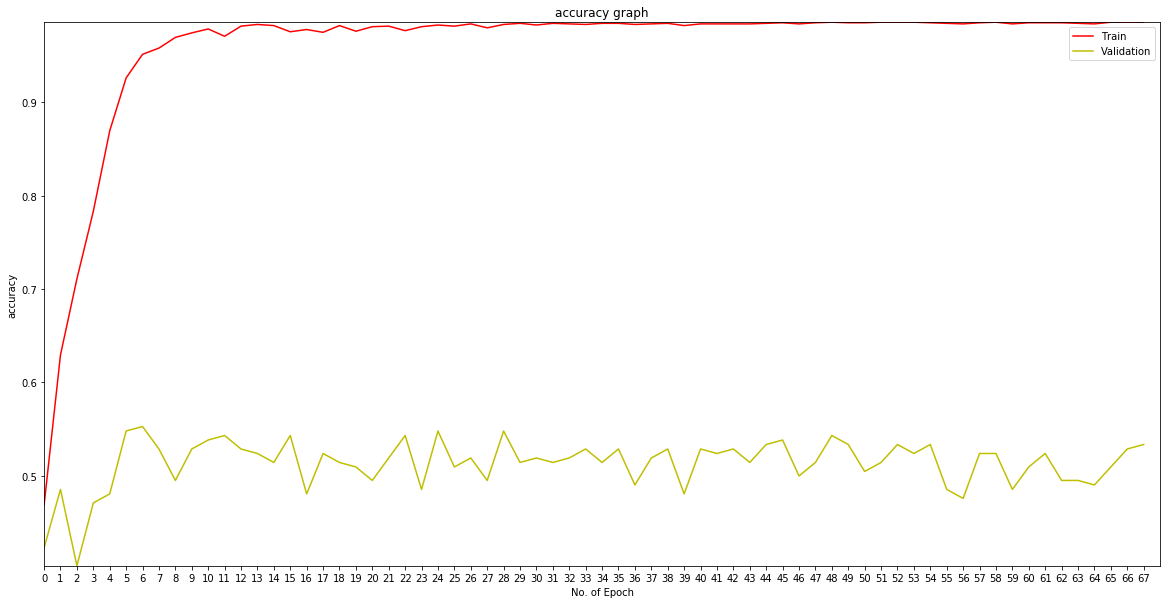

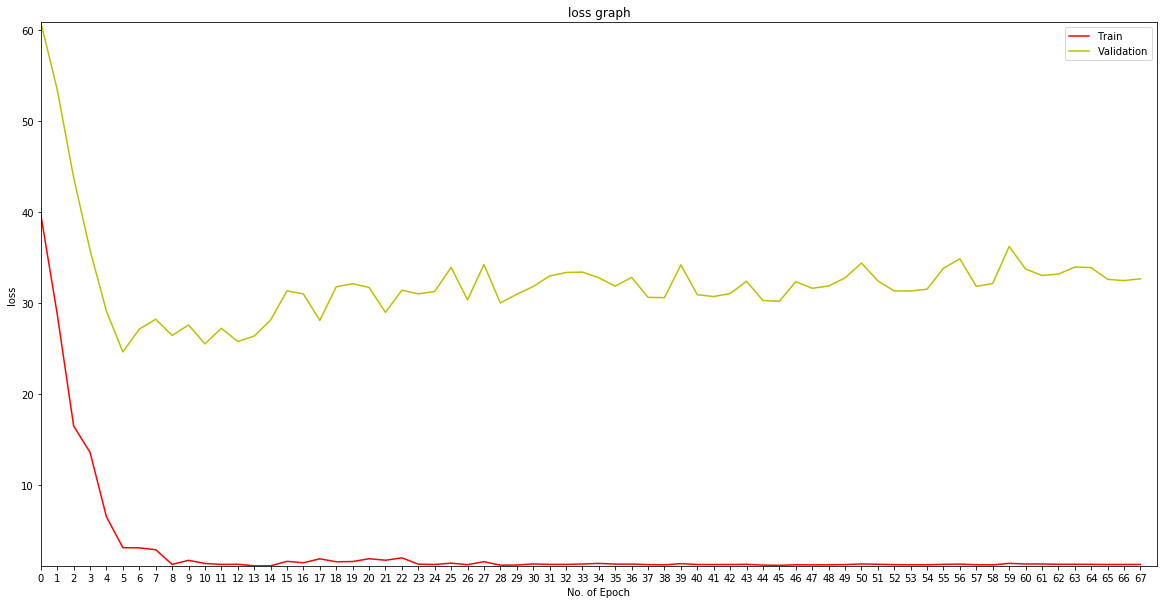

In [63]:
plot_graph(train_acc_hist,val_acc_hist,Title='accuracy graph')
plot_graph(tr_loss_hist,val_loss_hist,Title='loss graph')

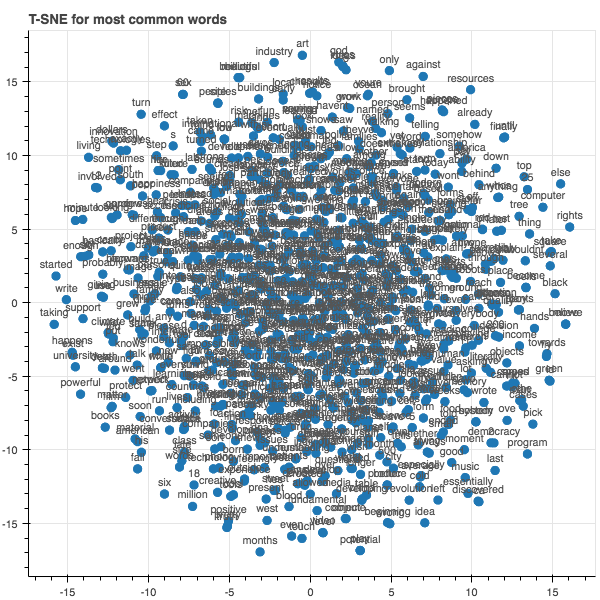

In [65]:
#tsne_plot(tokens,word2id,embedded)
Image(filename='src/random_do_tsne.png')


# Inference:    

What happens if you try alternative non-linearities (logistic sigmoid or ReLU instead of tanh)?
Using other activation functions such as ReLU/sigmoid didn't seemed much of improvement (in test acc.) in comparision with tanH.

What happens if you add dropout to the network?
In all the cases, Using Dropout aided me to perform good generalization (less overfiting) as it act as regularizer.

How would the code change if you wanted to add a second hidden layer?

There isn't much change. If fully_connected(...) is used then we would pass the activation function and regularizer, weight initilization etc. as parameters else if no high level layers API used then we explicitly create weight vector for the corresponding layer as Variable and initilize them. The regularizer (l2_loss) is explicitly assigned.

Project the embeddings of the labels onto 2 dimensions and visualise (each row of the projection matrix V corresponds a label embedding). Do you see anything interesting?

Performed it using the T-SNE plot.

How does the training algorithm affect the quality of the model?

Training over Glove does indicate improvement on accuracy. And looking at the T-SNE plot, it shows that the word embeddings are learned if weight vector are initilized with the Glove embedding vectors unlike the random initlization ('random' in model.Embed_Word(...)) which does indicate that the word aren't embedded properly though text classification (using 'random' weight init) is better than the random guess. 

#### Further comments:
Number of Layers: The network did overfit even with even with single layer. Therefore, It is not gonna improve performance by increasing the number of layers.

Word Embedding of trainable GloVe did perform well in comparision to GloVe fixed and Random embed vectors actually random vector did perform very bad (Do look at its visualization (T-SNE plot)).

If we focus on Text classification I think that there wasn't huge difference of accuracy among the three but I can't comment much on it as am yet to perform further hyperparameter tuning. 

Comment on number of hidden units: It started to overfit even with the units 60-70 but trying dropout on them didn't perform well when compared with dropout on 100 units. The reason seems to be that
on an average it requires atleast 50 units (drop_prob = 0.5). and 50 units because the embed vector is of 50 dimension. 


